In [227]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LinearRegression



In [2]:
def pullsqldata():
    """This function pulls the necessary columns and rows from the PostGRES DB into a Pandas Dataframe in order 
    to continue with our EDA """
    
    engine = create_engine("postgresql:///kc_housing")
    query = """
                SELECT *
                FROM rpsale AS s
                INNER JOIN resbldg AS b ON CONCAT(s.Major,s.Minor) = CONCAT(b.Major, b.Minor)
                INNER JOIN parcel AS p ON CONCAT(s.Major,s.Minor) = CONCAT(p.Major,p.Minor)
                WHERE EXTRACT(YEAR FROM CAST(documentdate AS DATE)) = 2018
                    AND p.proptype = 'R'
                ;"""
    kc_df = pd.read_sql(sql = query, con = engine)
    return kc_df
    

In [275]:
def clean_data_intial(df):
    """ This function cleans the housing data by removing outliers, sale price == 0, and irrelevant columns. 
    """
    #We chose a minimum sale vale of 10000 and a maximium sale value of 2 sigma
    df_clean = df[(df['saleprice']>10000) & (df['saleprice'] <  (2*df['saleprice'].std())+df['saleprice'].mean())]
    df_clean = df_clean[df_clean['sqftlot'] <  (2*df_clean['sqftlot'].std())+df_clean['sqftlot'].mean()]
    #These are irrelevant or highly covariant columns
    columns_to_drop = ['documentdate',
                       'excisetaxnbr',
                       'recordingnbr',
                       'volume',
                       'page',
                       'platnbr',
                       'plattype',
                       'platlot',
                       'platblock',
                        'sellername',
                        'buyername',
                        'streetname',
                        'streettype',
                        'directionsuffix',
                        
                        'buildingnumber',
                        'major',
                        'minor',
                        'bldggradevar',
                        'sqfthalffloor',
                        'sqft2ndfloor',
                        'sqftupperfloor',
                        'sqftunfinfull',
                        'sqftunfinhalf',
                        'sqfttotbasement',
                        'sqftfinbasement',
                        'brickstone',
                        'viewutilization',
                        'propname',
                        'platname',
                        'platlot',
                        'platblock',
                        'range',
                        'township',
                        'section',
                        'quartersection',
                        'area',
                        'subarea',
                        'specarea',
                        'specsubarea',
                        'levycode',
                        'districtname',
                        'currentzoning',
                        'topography',
                        'currentusedesignation',
                        'salewarning',
                        'wetland',
                        'stream',
                        'seismichazard',
                        'landslidehazard',
                        'address',
                        'airportnoise',
                        'contamination',
                        'dnrlease',
                         'coalminehazard',
                         'criticaldrainage',
                         'erosionhazard',
                         'landfillbuffer',
                         'hundredyrfloodplain',
                         'steepslopehazard',
                         'speciesofconcern',
                         'sensitiveareatract',
                         'daylightbasement',
                         'fraction',
                        'directionprefix', 'proptype','unbuildable', 'bldgnbr', 'pcntcomplete']
    df_clean.drop(columns=columns_to_drop, inplace = True)
    #The columns with Y or N need to be 1 or 0 to model
    df_clean['othernuisances'] = [i.strip() for i in df_clean['othernuisances']]
    df_clean.replace(('Y', 'N'), (1, 0), inplace=True)
    
    #To model the houses that take up more space of thier plot (smaller yard) we need a ratio feature
    #We assume an acturate metric of the house's footprint is the first floor plus any attached garage. This 
    #unfortunatley may not account for detached garages
    df_clean['footprint_ratio']=(df_clean['sqft1stfloor']+df_clean['sqftgarageattached'])/df_clean['sqftlot']
    df_clean.drop(columns = 'sqft1stfloor', inplace = True)
    
    #nbrliving units is classified data telling us if it is a duplex. We want to remove triplexes and create a duplex 
    #flag column
    
    triplex = df_clean.loc[df_clean['nbrlivingunits'] == 3]
    df_clean.drop(triplex.index, inplace= True, axis=0)
    df_clean['duplex'] = df_clean['nbrlivingunits'] - 1
    df_clean.drop(columns = 'nbrlivingunits', inplace = True)

    return df_clean
    

In [4]:
def recursive_feature_selection(n_features,indep_variables_df, dep_var):
    """
    n_features = number of features to select
    indep_variables = pandas dataframe containing the features to select from
    dep_var = pandas dataframe containing the feature to model \
    returns a list of features to include in model to best fit line
    """
    lr = LinearRegression()
    select = RFE(lr, n_features_to_select=n_features)
    select = select.fit(indep_variables_df, y= dep_var.values.ravel())
    selected_columns = indep_variables_df.columns[select.support_]
    return selected_columns

In [5]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [269]:
df = pullsqldata()

In [276]:
df_clean = clean_data_intial(df)

In [280]:
x = df_clean.drop(columns = 'saleprice')
y = df_clean['saleprice']


In [57]:
#engineer total baths
pi_1['bath_total_count']=pi_1['bathhalfcount']+pi_1['bath3qtrcount']+pi_1['bathfullcount']
pi_1.drop(columns = ['bathhalfcount','bath3qtrcount','bathfullcount'], inplace = True)

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [58]:
#engineer total porch space
pi_1['porch_sqft_total']=pi_1['sqftopenporch']+pi_1['sqftenclosedporch']
pi_1.drop(columns = ['sqftopenporch','sqftenclosedporch'], inplace = True)

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [59]:
#engineer age
pi_1['age']=2019 - pi_1['yrbuilt']
pi_1.drop(columns = ['yrbuilt'], inplace = True)

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [226]:
def make_housing_model(list_of_features, df, y):
    """
    
    """
    
    features = df[list_of_features]
    features = sm.add_constant(features)
    model = sm.OLS(y,features).fit()
    
    return model.summary() 
    

In [246]:
def check_feature_linearity(list_of_features, df, y):
    """
    """
    for column in list_of_features:
        plt.scatter(df[column], y, label=column, alpha = .05)
        plt.legend()
        plt.title(column)
        plt.show()

In [237]:


def check_feature_resid_dist(list_of_features, df, y):
    '''
    Visualizes the residiuals of a linear model in order to check the 
    assumptions. Shows both histogram of residual values and qq plot.
    
    !!!  Be sure to import scipy.stats as stats  !!!
    
    '''
    for feature in list_of_features:
        
        x = df[feature]
        x = sm.add_constant(x)
        model = sm.OLS(y,x).fit()
        pred_val = model.fittedvalues
        residuals = y.values - pred_val
        fig, ax = plt.subplots(1, 2, sharex=False, sharey=False)
        fig.set_size_inches(15,5)
        sns.distplot(residuals, ax = ax[0])
        sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45', ax = ax[1])
        fig.suptitle(feature)
        fig.show()
        
        

In [254]:
def check_feature_heteros(list_of_features, df, y):
    """
    Visualizes the heteroscedasticity of a linear model in order to check the 
    assumptions.
    """
    
    for feature in list_of_features:
        x = df[feature]
        x = sm.add_constant(x)
        model = sm.OLS(y,x).fit()
        fig = plt.figure(figsize=(15,8))

        fig = sm.graphics.plot_regress_exog(model, feature, fig=fig)
        plt.show()

# build a baseline model

In [281]:


baseline_features = ['sqfttotliving','sqftlot','footprint_ratio','duplex']
make_housing_model(baseline_features, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     3085.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:08:48   Log-Likelihood:            -3.9388e+05
No. Observations:               28048   AIC:                         7.878e+05
Df Residuals:                   28043   BIC:                         7.878e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.933e+05   6080.570     31.790      0.000    1.81e+05    2.05e+05
sqfttotliving     222.8360      2.142    104.038      0.000     218.638     227.034
sqftlot            -0.3854      0.155     -2.489      0.013      -0.689      -0.082
footprint_ratio  2.605e+05   1.75e+04     14.898      0.000    2.26e+05    2.95e+05
duplex           7.067e+04   1.64e+04      4.317      0.000    3.86e+04    1.03e+05
==============================================================================
Omnibus:                     3012.805   Durbin-Watson:                   0.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7871.146
Skew:                           0.615   Prob(JB):                         0.00
Kurtosis:                       5.285   Cond. No.                     1.77e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# check baseline model assumptions

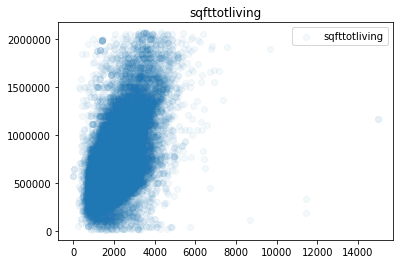

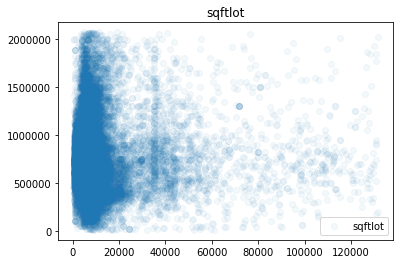

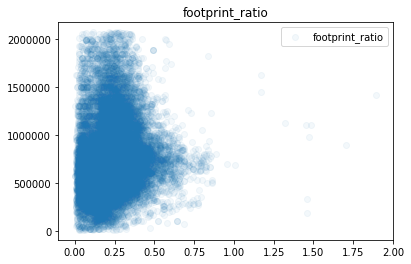

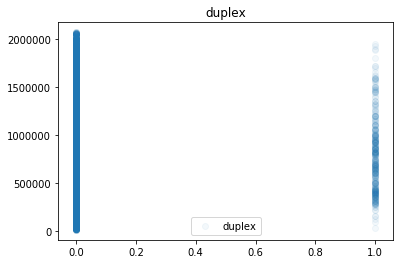

In [282]:
check_feature_linearity(baseline_features, x, y)

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py

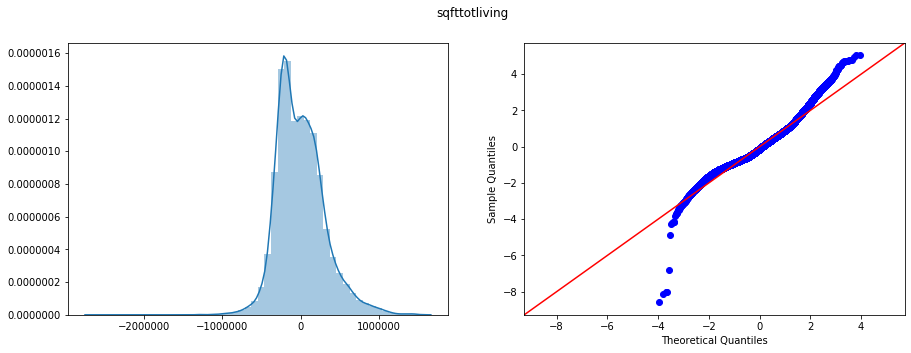

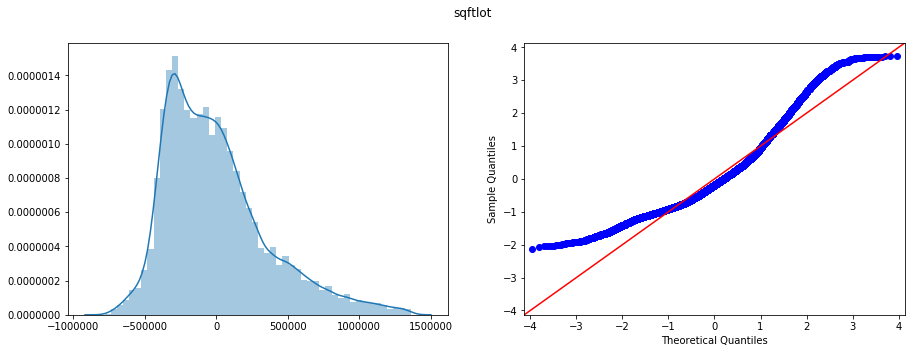

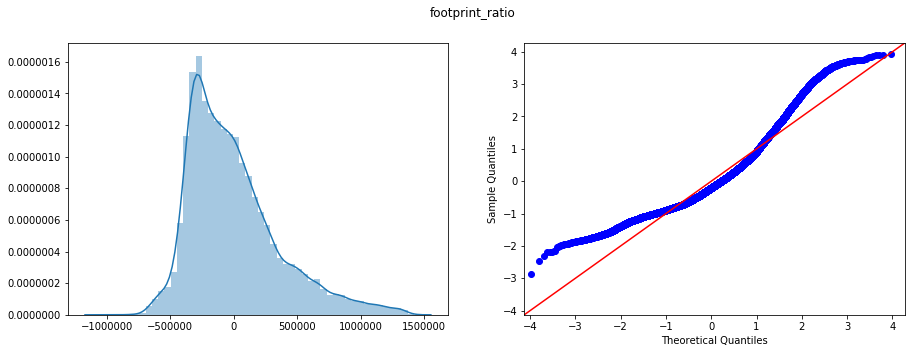

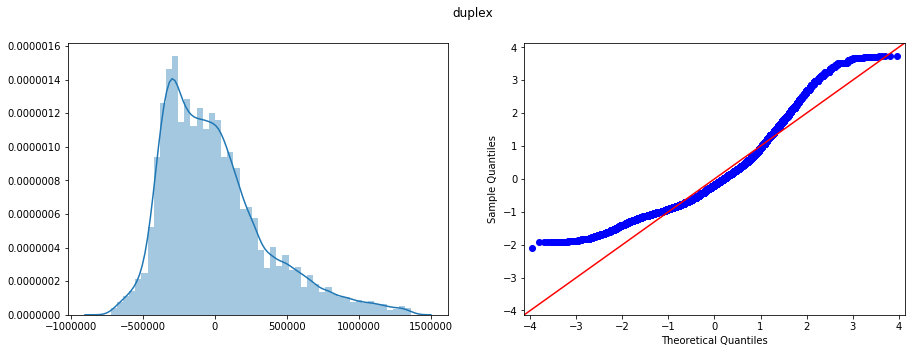

In [283]:
check_feature_resid_dist(baseline_features, x, y)

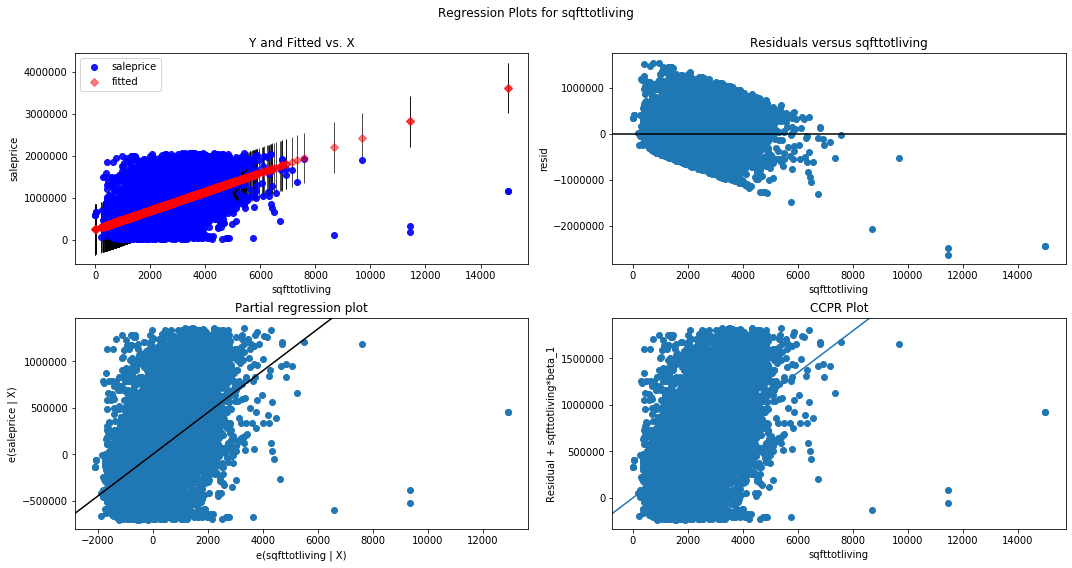

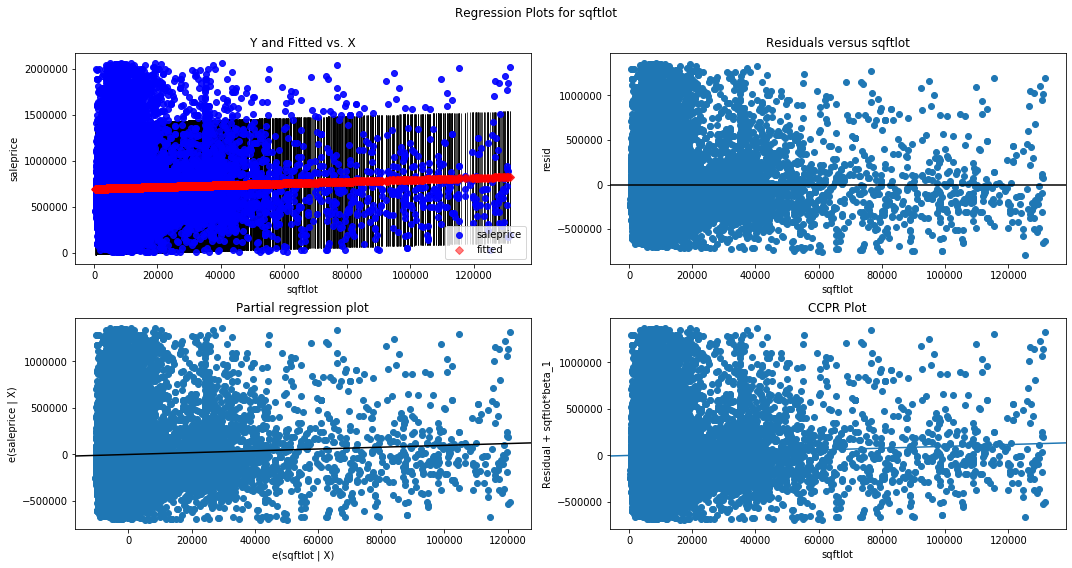

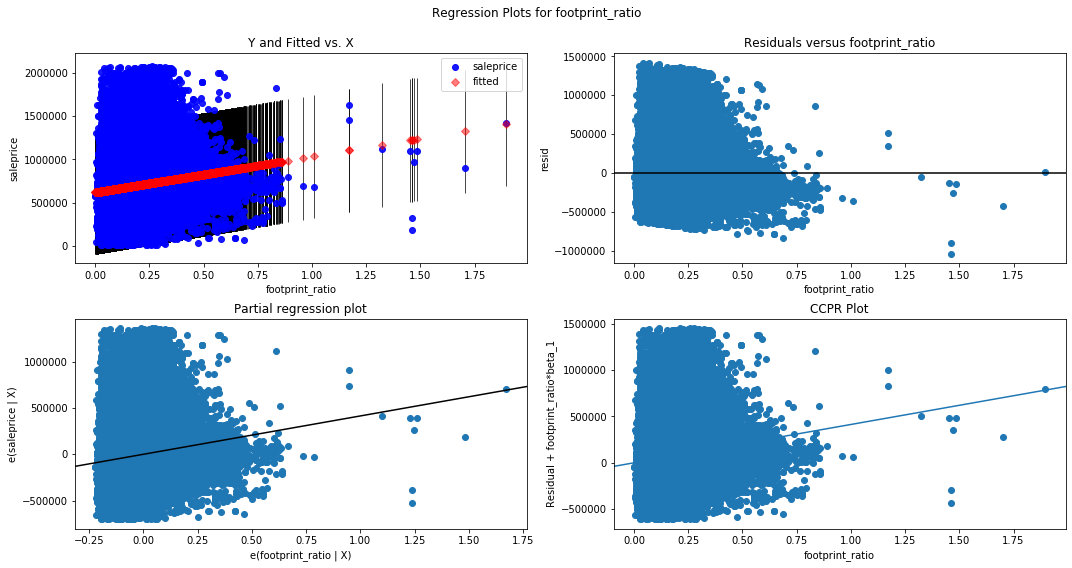

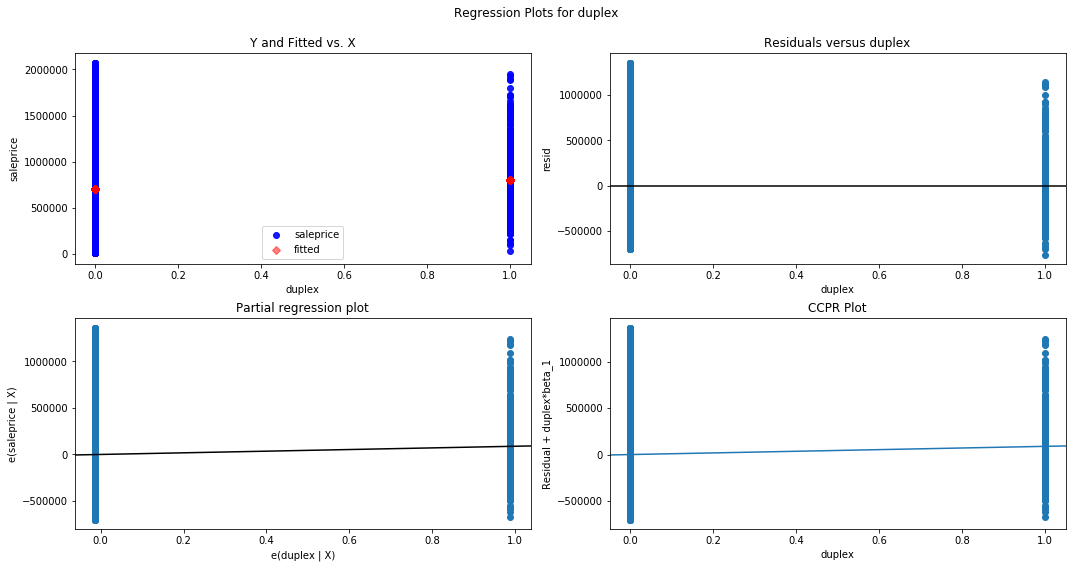

In [284]:
check_feature_heteros(baseline_features, x, y)

## Because The sqftlot seems to violoate assumption of linearity, lets remove it from the model

In [286]:
baseline_features = ['sqfttotliving','footprint_ratio','duplex']
make_housing_model(baseline_features, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     4110.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:10:08   Log-Likelihood:            -3.9388e+05
No. Observations:               28048   AIC:                         7.878e+05
Df Residuals:                   28044   BIC:                         7.878e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.868e+05   5493.038     34.008      0.000    1.76e+05    1.98e+05
sqfttotliving     221.4126      2.064    107.256      0.000     217.366     225.459
footprint_ratio  2.843e+05   1.47e+04     19.394      0.000    2.56e+05    3.13e+05
duplex           7.137e+04   1.64e+04      4.360      0.000    3.93e+04    1.03e+05
==============================================================================
Omnibus:                     3034.096   Durbin-Watson:                   0.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7990.036
Skew:                           0.617   Prob(JB):                         0.00
Kurtosis:                       5.305   Cond. No.                     2.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""